# 03-01 — Exploratory Data Analysis

Phase 3: understand the training data before modeling. Sanity checks, distributions,
correlations, visual galleries, failure analysis, door positions, and reference baselines.

UMAP exploration is in a separate notebook: [03-02_umap_exploration.ipynb](./03-02_umap_exploration.ipynb).
Full findings report: [reports/03-01_eda-findings.ipynb](../reports/03-01_eda-findings.ipynb) ([HTML](../reports/03-01_eda-findings.html)).

In [1]:
# Cell 0: Setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

from furnisher_surrogate.data import (
    load_apartments, ROOM_TYPES, ROOM_TYPE_TO_IDX, assign_splits,
)
from furnisher_surrogate.features import (
    area, aspect_ratio, n_vertices, door_rel_position,
    extract_features, extract_feature_matrix, extract_scores, FEATURE_NAMES,
)

plt.rcParams.update({"figure.dpi": 100, "figure.figsize": (10, 6)})

# Load data
apartments = load_apartments()
all_rooms = [r for a in apartments for r in a.rooms]
print(f"Loaded {len(apartments)} apartments, {len(all_rooms)} active rooms")

# Pre-compute features and scores
X = extract_feature_matrix(all_rooms)
y = extract_scores(all_rooms)
print(f"Feature matrix: {X.shape}, Score vector: {y.shape}")

Loaded 8322 apartments, 45880 active rooms


Feature matrix: (45880, 14), Score vector: (45880,)


In [2]:
# Cell 1: Sanity checks

def point_on_segment(p, a, b, tol=1e-4):
    """Check if point p lies on segment a->b within tolerance."""
    ab = b - a
    ap = p - a
    ab_len_sq = np.dot(ab, ab)
    if ab_len_sq < 1e-12:
        return np.linalg.norm(ap) < tol
    t = np.dot(ap, ab) / ab_len_sq
    if t < -tol or t > 1 + tol:
        return False
    proj = a + t * ab
    return np.linalg.norm(p - proj) < tol

def door_on_wall(room):
    """Check if the room's door lies on any polygon edge."""
    poly = room.polygon
    for i in range(len(poly) - 1):
        if point_on_segment(room.door, poly[i], poly[i + 1]):
            return True
    return False

checks = {}

# Record counts
checks["Apartment count == 8322"] = len(apartments) == 8322
checks["Room count == 45880"] = len(all_rooms) == 45880

# Missing values
null_scores = sum(1 for r in all_rooms if r.score is None)
checks[f"No null scores (found {null_scores})"] = null_scores == 0

# Score range
scores_oob = sum(1 for s in y if s < 0 or s > 100)
checks[f"All scores in [0,100] (OOB: {scores_oob})"] = scores_oob == 0

# Polygon validity: first == last vertex
not_closed = sum(1 for r in all_rooms if not np.array_equal(r.polygon[0], r.polygon[-1]))
checks[f"All polygons closed (not closed: {not_closed})"] = not_closed == 0

# Door on wall
door_off_wall = sum(1 for r in all_rooms if not door_on_wall(r))
checks[f"All doors on wall (off wall: {door_off_wall})"] = door_off_wall == 0

# Vertex counts
vert_counts = Counter(n_vertices(r) for r in all_rooms)
vert_str = ", ".join(f"{k}v:{v}" for k, v in sorted(vert_counts.items()))
checks[f"Vertex distribution: {vert_str}"] = True  # informational

print(f"{'Check':<55} {'Result':>6}")
print("-" * 63)
all_pass = True
for desc, passed in checks.items():
    status = "PASS" if passed else "FAIL"
    if not passed:
        all_pass = False
    print(f"{desc:<55} {status:>6}")

if all_pass:
    print("\nAll sanity checks passed.")
else:
    print("\nSome checks FAILED — investigate before proceeding.")

Check                                                   Result
---------------------------------------------------------------
Apartment count == 8322                                   PASS
Room count == 45880                                       PASS
No null scores (found 0)                                  PASS
All scores in [0,100] (OOB: 0)                            PASS
All polygons closed (not closed: 0)                       PASS
All doors on wall (off wall: 0)                           PASS
Vertex distribution: 4v:28062, 6v:12509, 8v:5309          PASS

All sanity checks passed.


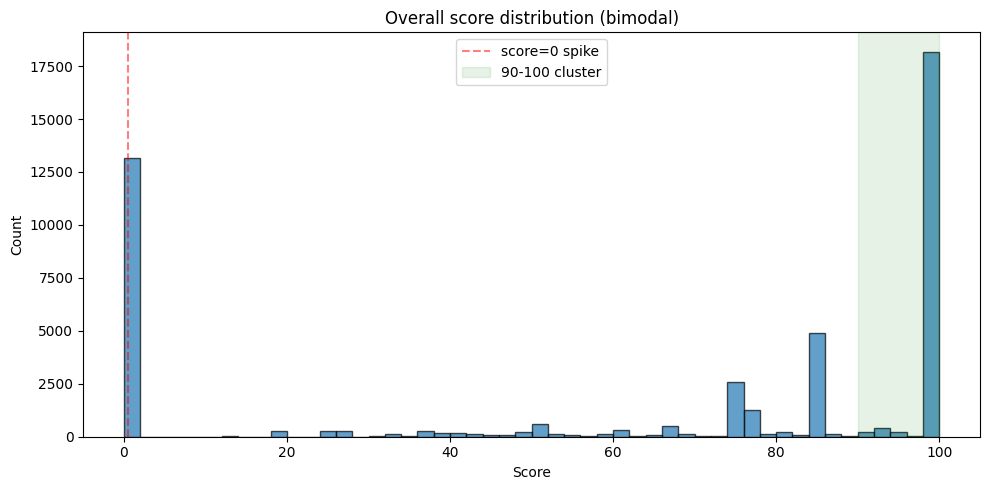

Mean: 62.2, Median: 85.0, Std: 42.6
Score=0: 28.6% (13137 rooms)
Score>=90: 41.6% (19084 rooms)


In [3]:
# Cell 2: Score distribution — overall
fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(y, bins=50, edgecolor="black", alpha=0.7)
ax.axvline(0.5, color="red", linestyle="--", alpha=0.5, label="score=0 spike")
ax.axvspan(90, 100, alpha=0.1, color="green", label="90-100 cluster")
ax.set_xlabel("Score")
ax.set_ylabel("Count")
ax.set_title("Overall score distribution (bimodal)")
ax.legend()
plt.tight_layout()
plt.show()

pct_zero = np.mean(y == 0) * 100
pct_90plus = np.mean(y >= 90) * 100
print(f"Mean: {y.mean():.1f}, Median: {np.median(y):.1f}, Std: {y.std():.1f}")
print(f"Score=0: {pct_zero:.1f}% ({int(np.sum(y == 0))} rooms)")
print(f"Score>=90: {pct_90plus:.1f}% ({int(np.sum(y >= 90))} rooms)")

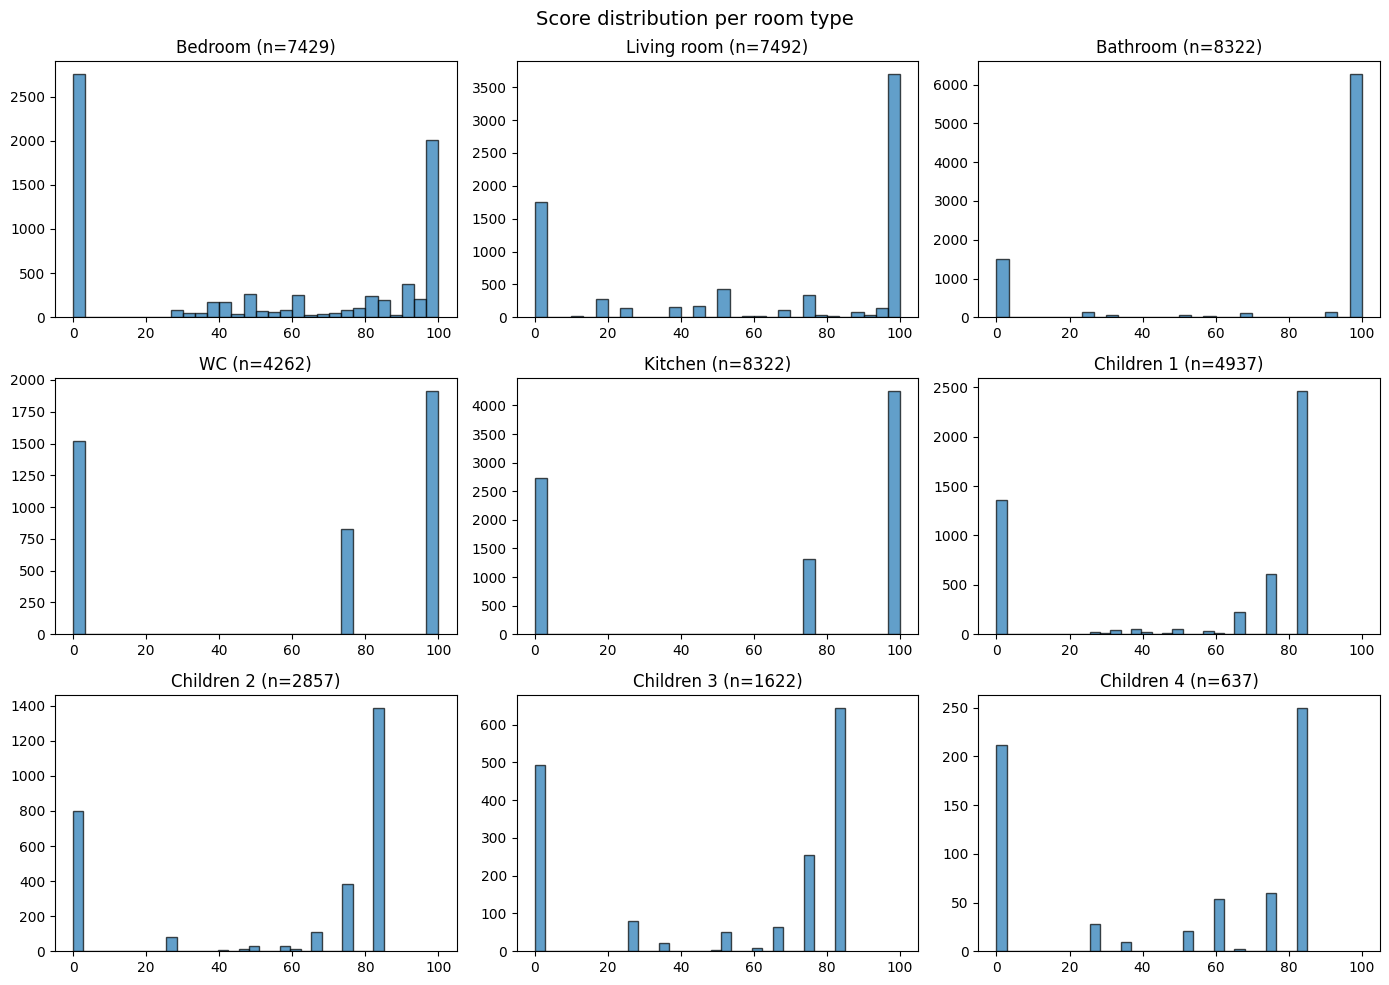

,room_type,n,mean,median,std,%=0,%>=90
0,Bedroom,7429,50.8,54.0,43.1,37.2%,35.0%
1,Living room,7492,64.0,95.8,42.3,23.5%,51.8%
2,Bathroom,8322,79.2,100.0,39.1,18.0%,77.1%
3,WC,4262,59.5,75.0,45.2,35.6%,45.0%
4,Kitchen,8322,63.1,100.0,45.0,32.9%,51.2%
5,Children 1,4937,57.3,76.2,36.7,27.5%,0.0%
6,Children 2,2857,56.6,76.2,37.1,28.1%,0.0%
7,Children 3,1622,52.2,76.2,37.3,30.3%,0.0%
8,Children 4,637,49.3,61.2,37.6,33.3%,0.0%


In [4]:
# Cell 3: Score distribution — per room type
fig, axes = plt.subplots(3, 3, figsize=(14, 10))
for ax, rt in zip(axes.flat, ROOM_TYPES):
    scores_rt = np.array([r.score for r in all_rooms if r.room_type == rt])
    ax.hist(scores_rt, bins=30, edgecolor="black", alpha=0.7)
    ax.set_title(f"{rt} (n={len(scores_rt)})")
    ax.set_xlim(-5, 105)
plt.suptitle("Score distribution per room type", fontsize=14)
plt.tight_layout()
plt.show()

# Summary table
rows = []
for rt in ROOM_TYPES:
    s = np.array([r.score for r in all_rooms if r.room_type == rt])
    rows.append({
        "room_type": rt, "n": len(s),
        "mean": f"{s.mean():.1f}", "median": f"{np.median(s):.1f}",
        "std": f"{s.std():.1f}",
        "%=0": f"{np.mean(s == 0) * 100:.1f}%",
        "%>=90": f"{np.mean(s >= 90) * 100:.1f}%",
    })
pd.DataFrame(rows)

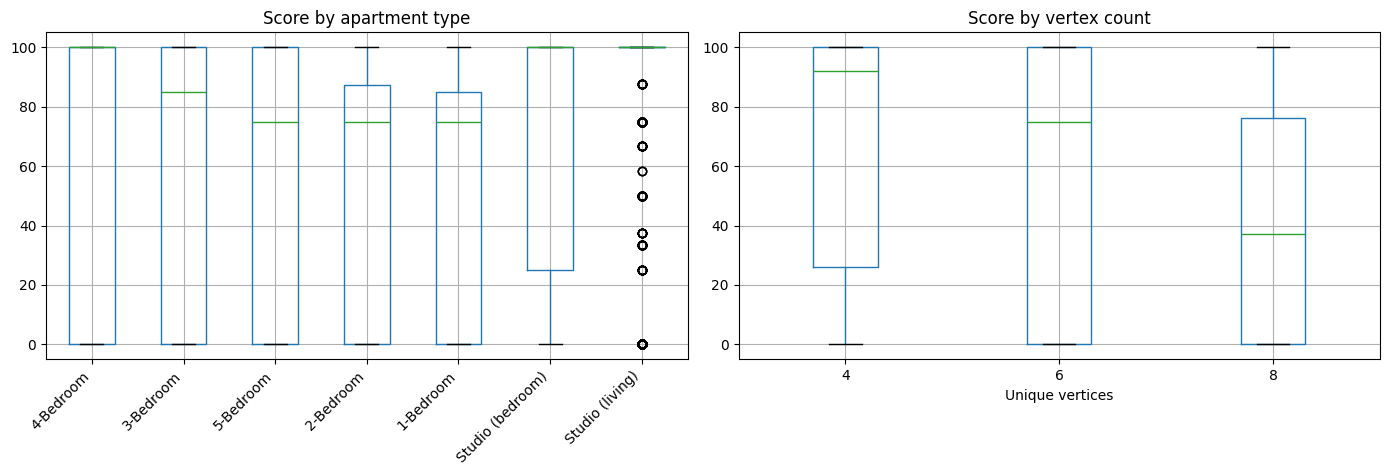

In [5]:
# Cell 4: Score by apartment type + by vertex count
df_all = pd.DataFrame({
    "score": y,
    "room_type": [r.room_type for r in all_rooms],
    "apt_type": [r.apartment_type for r in all_rooms],
    "n_vertices": [n_vertices(r) for r in all_rooms],
    "area": X[:, 0],
    "aspect_ratio": X[:, 1],
})

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# By apartment type
apt_types_sorted = df_all.groupby("apt_type")["score"].median().sort_values().index
df_all.boxplot(column="score", by="apt_type", ax=ax1, positions=range(len(apt_types_sorted)),
               vert=True)
ax1.set_xticklabels(apt_types_sorted, rotation=45, ha="right")
ax1.set_title("Score by apartment type")
ax1.set_xlabel("")
fig.suptitle("")

# By vertex count
df_all.boxplot(column="score", by="n_vertices", ax=ax2)
ax2.set_title("Score by vertex count")
ax2.set_xlabel("Unique vertices")
fig.suptitle("")

plt.tight_layout()
plt.show()

C:\Users\MartinBielik\AppData\Local\Temp\ipykernel_88744\3448113071.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0].boxplot([area_by_type[rt] for rt in ROOM_TYPES], labels=ROOM_TYPES)


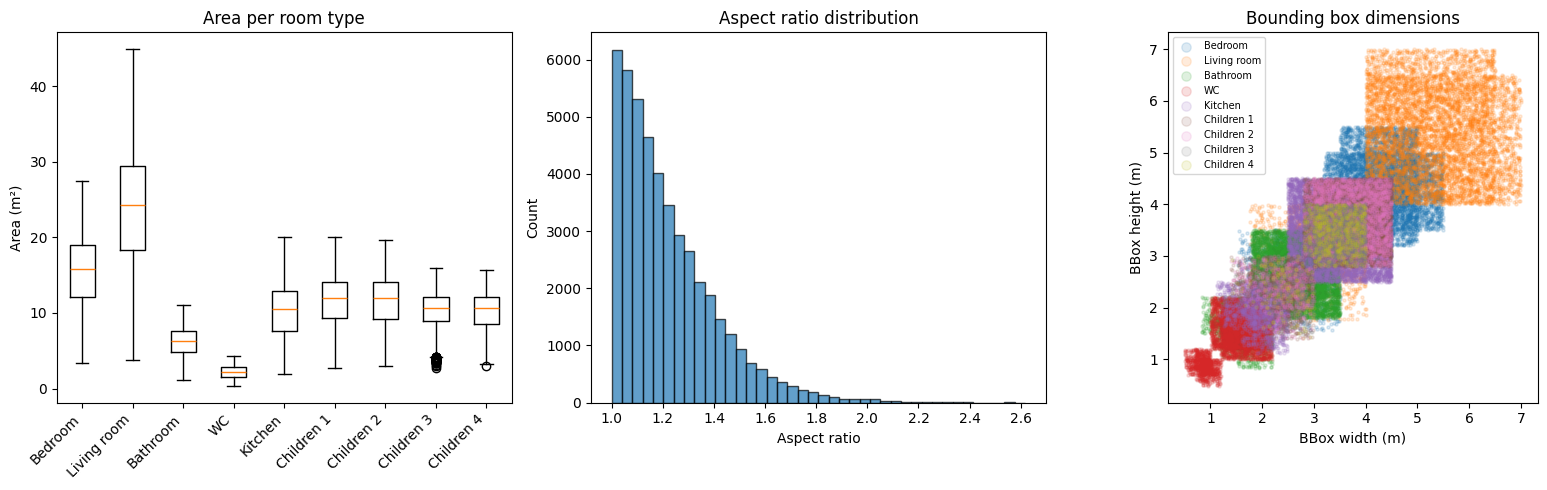

In [6]:
# Cell 5: Geometry distributions
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Area per room type (box plot)
area_by_type = {rt: [area(r) for r in all_rooms if r.room_type == rt] for rt in ROOM_TYPES}
axes[0].boxplot([area_by_type[rt] for rt in ROOM_TYPES], labels=ROOM_TYPES)
axes[0].set_xticklabels(ROOM_TYPES, rotation=45, ha="right")
axes[0].set_ylabel("Area (m\u00b2)")
axes[0].set_title("Area per room type")

# Aspect ratio histogram
all_ar = X[:, 1]
axes[1].hist(all_ar, bins=40, edgecolor="black", alpha=0.7)
axes[1].set_xlabel("Aspect ratio")
axes[1].set_ylabel("Count")
axes[1].set_title("Aspect ratio distribution")

# BBox width vs height
widths, heights = [], []
room_types_list = []
for r in all_rooms:
    mins = r.polygon.min(axis=0)
    maxs = r.polygon.max(axis=0)
    widths.append(maxs[0] - mins[0])
    heights.append(maxs[1] - mins[1])
    room_types_list.append(r.room_type)

for rt in ROOM_TYPES:
    mask = [t == rt for t in room_types_list]
    w = np.array(widths)[mask]
    h = np.array(heights)[mask]
    axes[2].scatter(w, h, alpha=0.15, s=5, label=rt)
axes[2].set_xlabel("BBox width (m)")
axes[2].set_ylabel("BBox height (m)")
axes[2].set_title("Bounding box dimensions")
axes[2].legend(fontsize=7, markerscale=3)
axes[2].set_aspect("equal")

plt.tight_layout()
plt.show()

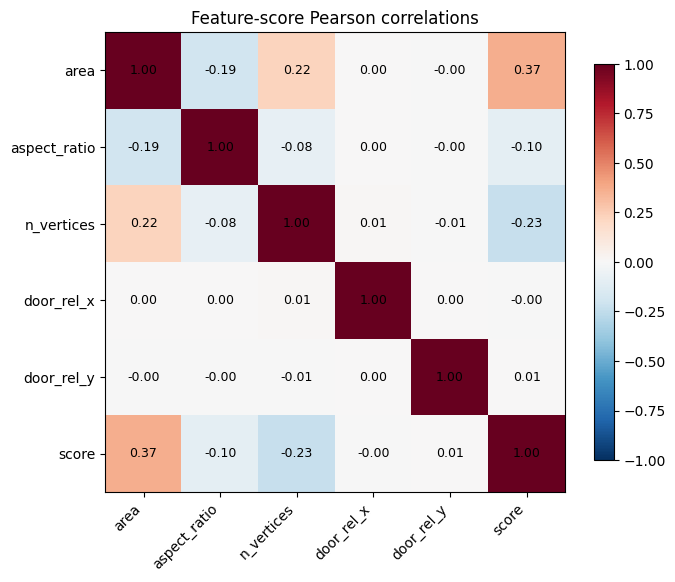

Correlations with score:
  area            r = +0.367
  n_vertices      r = -0.233
  aspect_ratio    r = -0.101
  door_rel_y      r = +0.006
  door_rel_x      r = -0.000


In [7]:
# Cell 6: Correlation matrix
numeric_cols = ["area", "aspect_ratio", "n_vertices", "door_rel_x", "door_rel_y"]
df_corr = pd.DataFrame(X[:, :5], columns=numeric_cols)
df_corr["score"] = y

corr = df_corr.corr()

fig, ax = plt.subplots(figsize=(7, 6))
im = ax.imshow(corr.values, cmap="RdBu_r", vmin=-1, vmax=1)
ax.set_xticks(range(len(corr.columns)))
ax.set_yticks(range(len(corr.columns)))
ax.set_xticklabels(corr.columns, rotation=45, ha="right")
ax.set_yticklabels(corr.columns)
for i in range(len(corr)):
    for j in range(len(corr)):
        ax.text(j, i, f"{corr.values[i, j]:.2f}", ha="center", va="center", fontsize=9)
fig.colorbar(im, ax=ax, shrink=0.8)
ax.set_title("Feature-score Pearson correlations")
plt.tight_layout()
plt.show()

print("Correlations with score:")
score_corr = corr["score"].drop("score").sort_values(key=abs, ascending=False)
for feat, val in score_corr.items():
    print(f"  {feat:<15} r = {val:+.3f}")

C:\Users\MartinBielik\AppData\Local\Temp\ipykernel_88744\4008417256.py:45: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.92, 0.97])


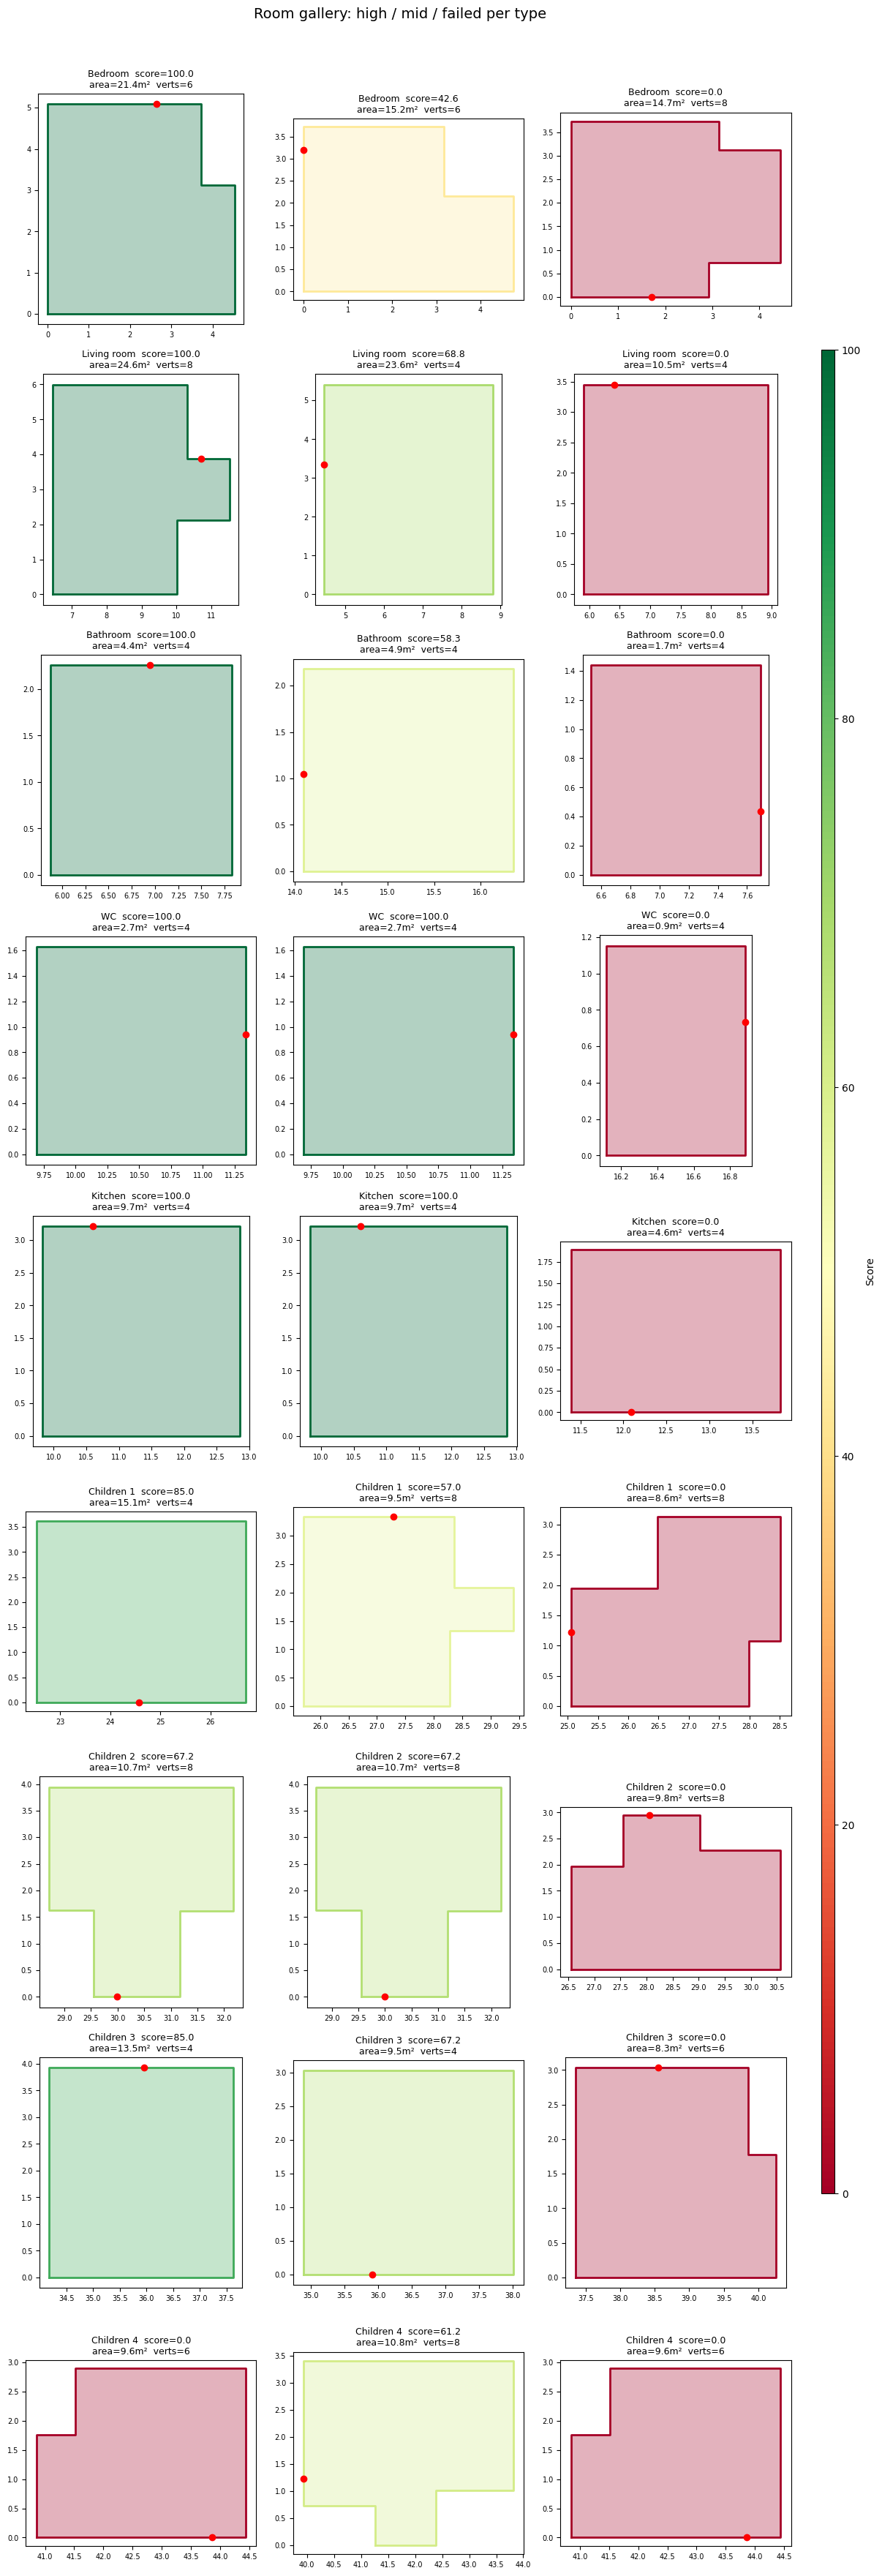

In [8]:
# Cell 7: Room gallery — color by score
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

cmap = plt.cm.RdYlGn
norm = Normalize(vmin=0, vmax=100)

fig, axes = plt.subplots(9, 3, figsize=(12, 36))

for row, rt in enumerate(ROOM_TYPES):
    rooms_rt = [r for r in all_rooms if r.room_type == rt]
    scores_rt = np.array([r.score for r in rooms_rt])

    # Pick: one high (>=90), one mid (~50), one failed (=0)
    high_idx = np.where(scores_rt >= 90)[0]
    mid_idx = np.where((scores_rt >= 40) & (scores_rt < 70))[0]
    zero_idx = np.where(scores_rt == 0)[0]

    picks = []
    for idx_arr, fallback_label in [(high_idx, "high"), (mid_idx, "mid"), (zero_idx, "zero")]:
        if len(idx_arr) > 0:
            picks.append(rooms_rt[idx_arr[0]])
        else:
            picks.append(rooms_rt[0])  # fallback

    for col, room in enumerate(picks):
        ax = axes[row, col]
        poly = room.polygon
        color = cmap(norm(room.score))
        ax.fill(poly[:, 0], poly[:, 1], alpha=0.3, color=color)
        ax.plot(poly[:, 0], poly[:, 1], color=color, linewidth=2)
        ax.plot(*room.door, "ro", markersize=6)
        a = area(room)
        nv = n_vertices(room)
        ax.set_title(f"{rt}  score={room.score}\narea={a:.1f}m\u00b2  verts={nv}", fontsize=9)
        ax.set_aspect("equal")
        ax.tick_params(labelsize=7)

# Colorbar
fig.subplots_adjust(right=0.92)
cbar_ax = fig.add_axes([0.94, 0.15, 0.015, 0.7])
fig.colorbar(ScalarMappable(norm=norm, cmap=cmap), cax=cbar_ax, label="Score")

plt.suptitle("Room gallery: high / mid / failed per type", fontsize=14, x=0.46)
plt.tight_layout(rect=[0, 0, 0.92, 0.97])
plt.show()

Failed rooms (score=0): 13137
Non-failed rooms:       32743

  room_type  failed  total fail_rate
    Bedroom    2761   7429     37.2%
Living room    1760   7492     23.5%
   Bathroom    1498   8322     18.0%
         WC    1519   4262     35.6%
    Kitchen    2737   8322     32.9%
 Children 1    1356   4937     27.5%
 Children 2     802   2857     28.1%
 Children 3     492   1622     30.3%
 Children 4     212    637     33.3%


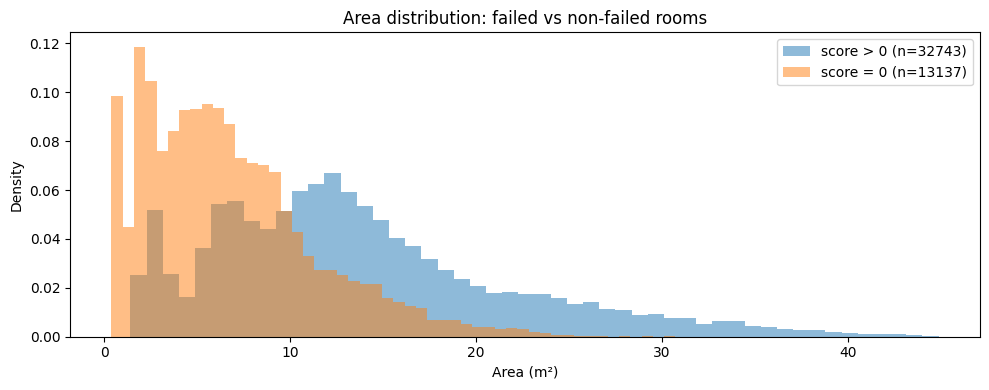

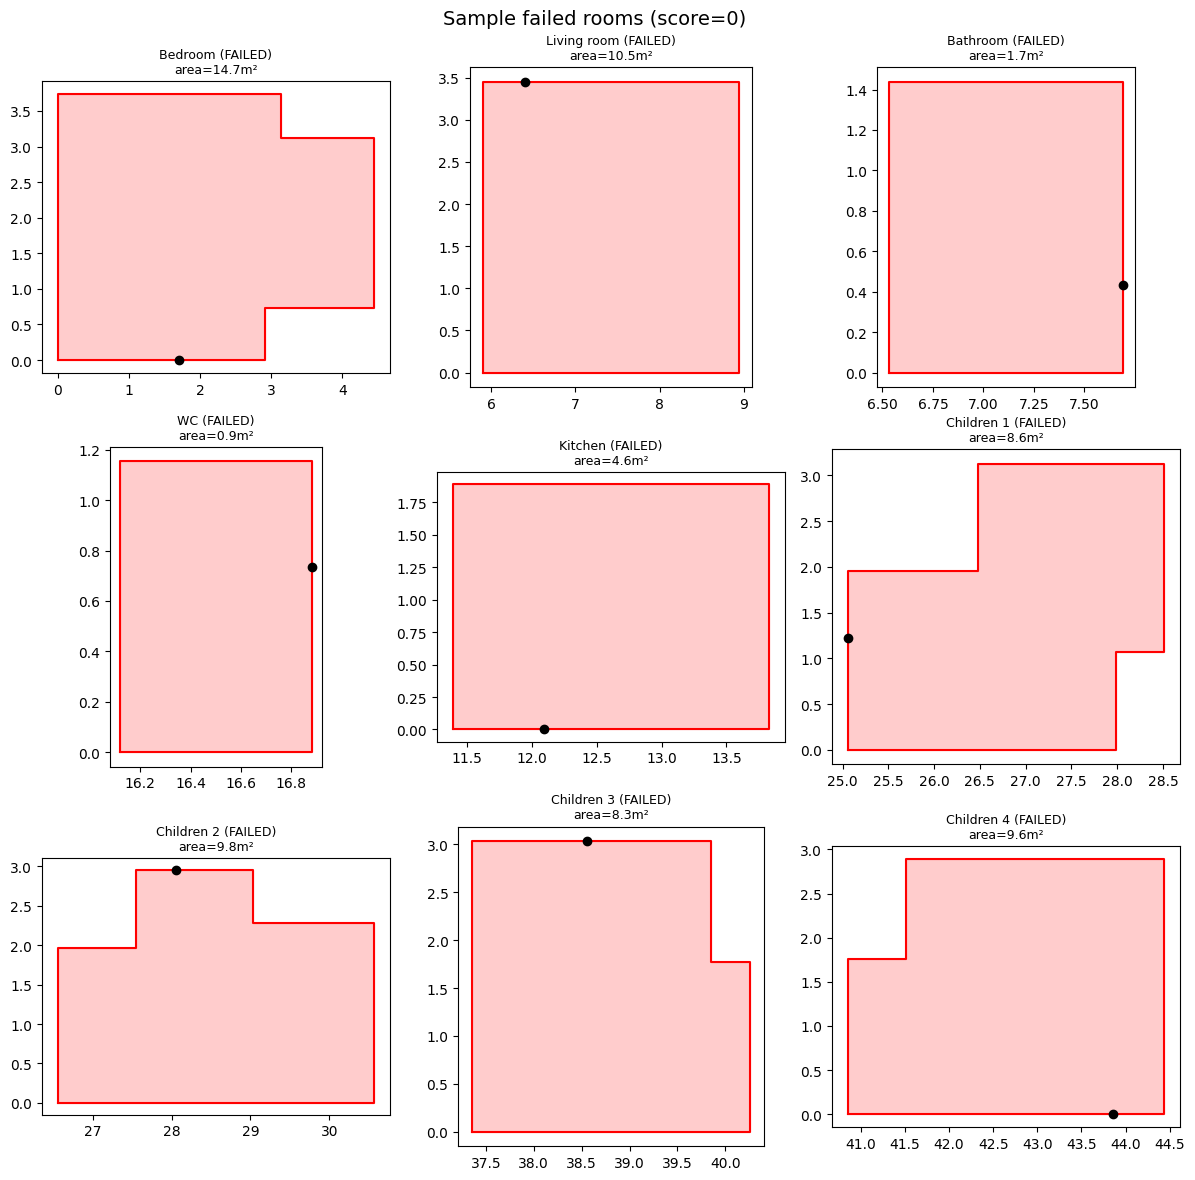

In [9]:
# Cell 8: Score=0 failure analysis
failed = [r for r in all_rooms if r.score == 0]
nonfailed = [r for r in all_rooms if r.score > 0]
print(f"Failed rooms (score=0): {len(failed)}")
print(f"Non-failed rooms:       {len(nonfailed)}")

# Failures per room type
fail_counts = Counter(r.room_type for r in failed)
total_counts = Counter(r.room_type for r in all_rooms)

rows = []
for rt in ROOM_TYPES:
    fc = fail_counts.get(rt, 0)
    tc = total_counts[rt]
    rows.append({"room_type": rt, "failed": fc, "total": tc, "fail_rate": f"{fc/tc*100:.1f}%"})
print()
print(pd.DataFrame(rows).to_string(index=False))

# Area distributions: failed vs non-failed
fig, ax = plt.subplots(figsize=(10, 4))
areas_fail = np.array([area(r) for r in failed])
areas_ok = np.array([area(r) for r in nonfailed])
ax.hist(areas_ok, bins=50, alpha=0.5, label=f"score > 0 (n={len(nonfailed)})", density=True)
ax.hist(areas_fail, bins=50, alpha=0.5, label=f"score = 0 (n={len(failed)})", density=True)
ax.set_xlabel("Area (m\u00b2)")
ax.set_ylabel("Density")
ax.set_title("Area distribution: failed vs non-failed rooms")
ax.legend()
plt.tight_layout()
plt.show()

# Sample failed rooms (one per type if possible)
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
fail_by_type = {}
for r in failed:
    if r.room_type not in fail_by_type:
        fail_by_type[r.room_type] = r

for ax, rt in zip(axes.flat, ROOM_TYPES):
    if rt in fail_by_type:
        room = fail_by_type[rt]
        poly = room.polygon
        ax.fill(poly[:, 0], poly[:, 1], alpha=0.2, color="red")
        ax.plot(poly[:, 0], poly[:, 1], "r-", linewidth=1.5)
        ax.plot(*room.door, "ko", markersize=6)
        ax.set_title(f"{rt} (FAILED)\narea={area(room):.1f}m\u00b2", fontsize=9)
    else:
        ax.set_title(f"{rt}\n(no failures)", fontsize=9)
    ax.set_aspect("equal")

plt.suptitle("Sample failed rooms (score=0)", fontsize=14)
plt.tight_layout()
plt.show()

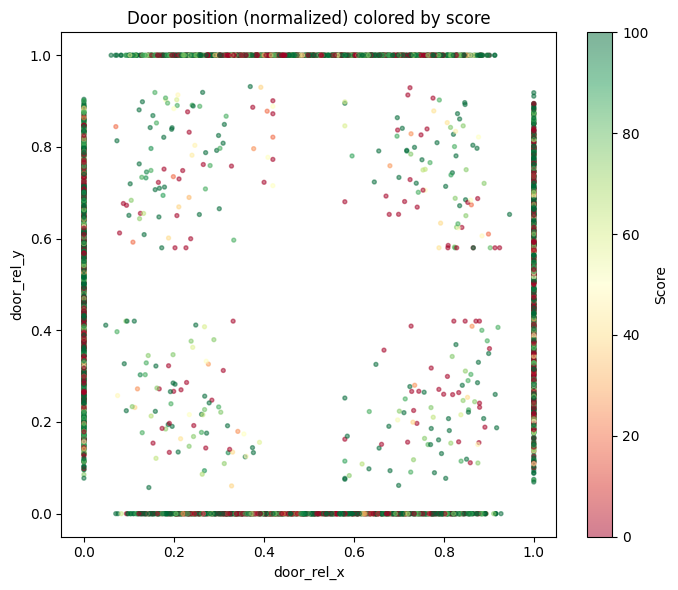

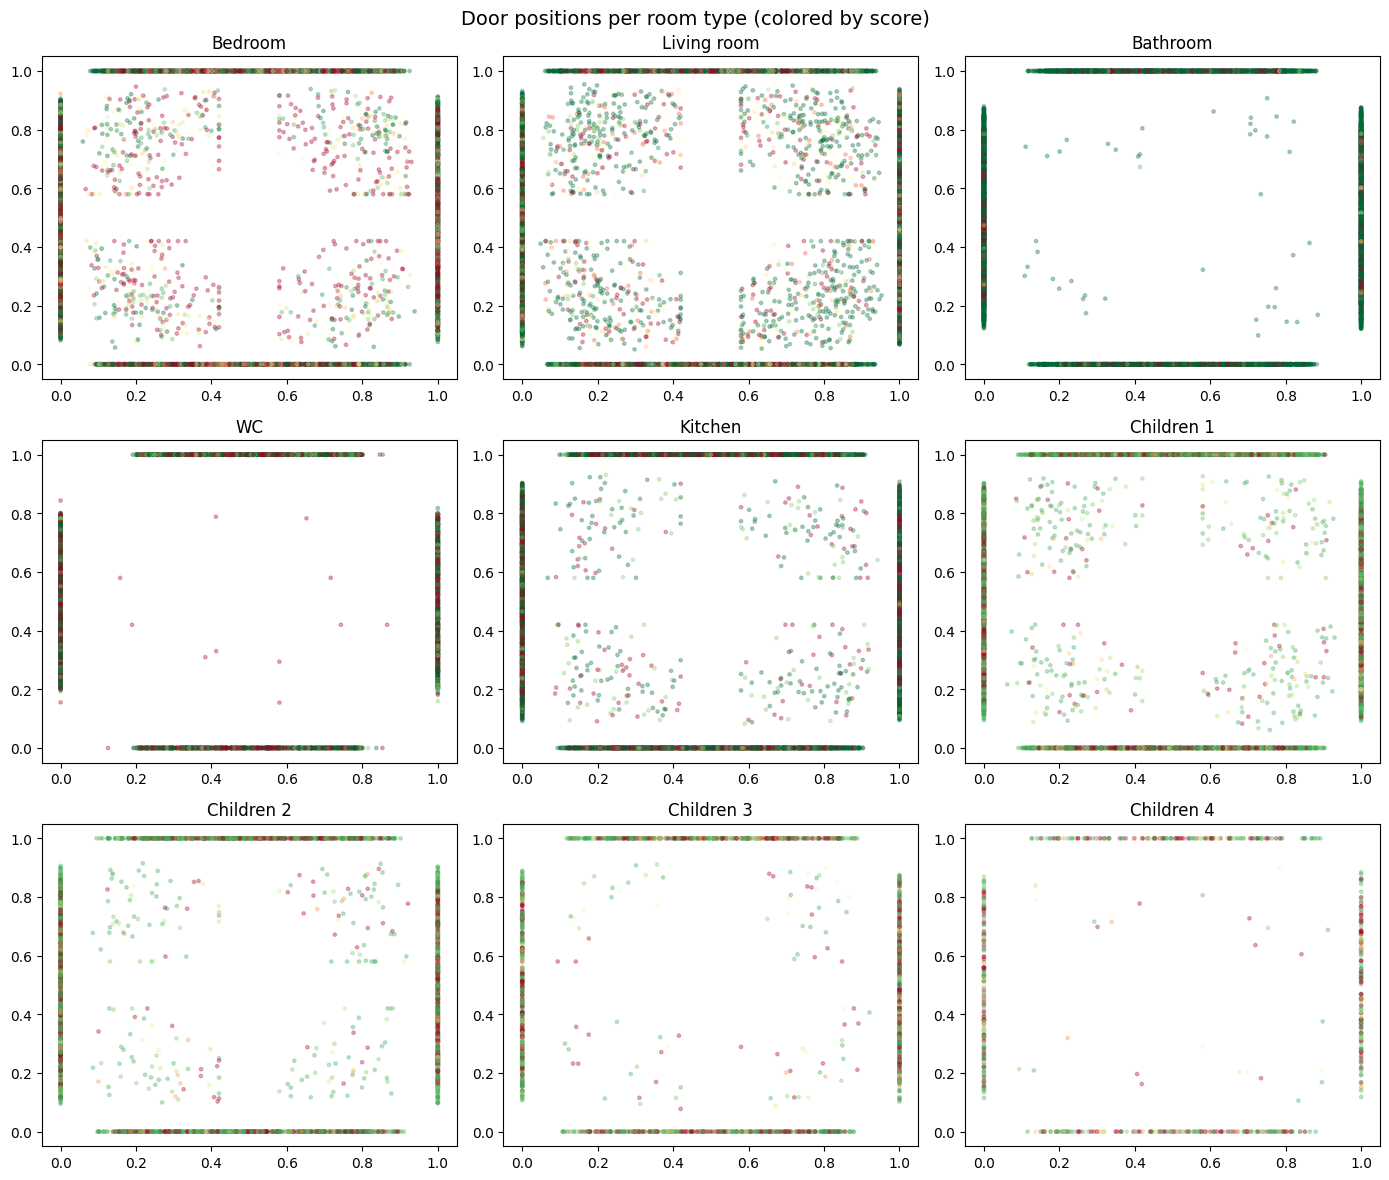

Room type        corr(dx,score)  corr(dy,score)
-----------------------------------------------
Bedroom                  -0.002          +0.012
Living room              +0.011          +0.004
Bathroom                 -0.009          -0.007
WC                       +0.017          -0.000
Kitchen                  +0.003          +0.004
Children 1               +0.009          +0.026
Children 2               -0.023          +0.018
Children 3               -0.044          +0.018
Children 4               +0.000          -0.002


In [10]:
# Cell 9: Door position analysis
door_x = X[:, 3]  # door_rel_x
door_y = X[:, 4]  # door_rel_y

# Scatter: door position colored by score (subsample for visibility)
rng = np.random.default_rng(42)
sample_idx = rng.choice(len(all_rooms), size=min(5000, len(all_rooms)), replace=False)

fig, ax = plt.subplots(figsize=(7, 6))
sc = ax.scatter(door_x[sample_idx], door_y[sample_idx], c=y[sample_idx],
                cmap="RdYlGn", s=8, alpha=0.5, vmin=0, vmax=100)
fig.colorbar(sc, ax=ax, label="Score")
ax.set_xlabel("door_rel_x")
ax.set_ylabel("door_rel_y")
ax.set_title("Door position (normalized) colored by score")
plt.tight_layout()
plt.show()

# Per-room-type door positions
fig, axes = plt.subplots(3, 3, figsize=(14, 12))
for ax, rt in zip(axes.flat, ROOM_TYPES):
    mask = np.array([r.room_type == rt for r in all_rooms])
    sc = ax.scatter(door_x[mask], door_y[mask], c=y[mask],
                    cmap="RdYlGn", s=6, alpha=0.3, vmin=0, vmax=100)
    ax.set_title(rt)
    ax.set_xlim(-0.05, 1.05)
    ax.set_ylim(-0.05, 1.05)
plt.suptitle("Door positions per room type (colored by score)", fontsize=14)
plt.tight_layout()
plt.show()

# Correlation: door position vs score per room type
print(f"{'Room type':<15} {'corr(dx,score)':>15} {'corr(dy,score)':>15}")
print("-" * 47)
for rt in ROOM_TYPES:
    mask = np.array([r.room_type == rt for r in all_rooms])
    if mask.sum() > 2:
        cx = np.corrcoef(door_x[mask], y[mask])[0, 1]
        cy = np.corrcoef(door_y[mask], y[mask])[0, 1]
        print(f"{rt:<15} {cx:>+15.3f} {cy:>+15.3f}")

In [11]:
# Cell 10: Reference metrics

# Naive baseline: predict mean score per room type
mean_by_type = {}
for rt in ROOM_TYPES:
    s = np.array([r.score for r in all_rooms if r.room_type == rt])
    mean_by_type[rt] = s.mean()

y_pred_naive = np.array([mean_by_type[r.room_type] for r in all_rooms])
naive_mae = np.mean(np.abs(y - y_pred_naive))
print(f"Naive baseline MAE (predict room-type mean): {naive_mae:.2f}")

# Per-type MAE
print(f"\n{'Room type':<15} {'Mean score':>10} {'MAE':>8} {'%=0':>8} {'n':>8}")
print("-" * 51)
for rt in ROOM_TYPES:
    mask = np.array([r.room_type == rt for r in all_rooms])
    s = y[mask]
    mae = np.mean(np.abs(s - mean_by_type[rt]))
    pct0 = np.mean(s == 0) * 100
    print(f"{rt:<15} {mean_by_type[rt]:>10.1f} {mae:>8.2f} {pct0:>7.1f}% {len(s):>8}")

# Feature-score correlations (all rooms)
print("\nFeature-score Pearson correlations:")
for i, name in enumerate(FEATURE_NAMES):
    r_val = np.corrcoef(X[:, i], y)[0, 1]
    print(f"  {name:<25} r = {r_val:+.3f}")

# Area threshold: failure rate by area bin per room type
print("\nArea threshold analysis (area below which >50% fail):")
for rt in ROOM_TYPES:
    rooms_rt = [(area(r), r.score) for r in all_rooms if r.room_type == rt]
    if not rooms_rt:
        continue
    areas_rt = np.array([a for a, _ in rooms_rt])
    scores_rt = np.array([s for _, s in rooms_rt])
    thresholds = np.percentile(areas_rt, [5, 10, 15, 20, 25])
    found = False
    for thr in thresholds:
        below = scores_rt[areas_rt <= thr]
        if len(below) > 5 and np.mean(below == 0) > 0.5:
            print(f"  {rt:<15} area <= {thr:.1f} m\u00b2 -> {np.mean(below == 0)*100:.0f}% fail (n={len(below)})")
            found = True
            break
    if not found:
        print(f"  {rt:<15} no clear area failure threshold")

# Inter-room correlation within apartments
pair_scores = []
for apt in apartments:
    if len(apt.rooms) >= 2:
        room_scores = [r.score for r in apt.rooms]
        for i in range(len(room_scores)):
            for j in range(i + 1, len(room_scores)):
                pair_scores.append((room_scores[i], room_scores[j]))

pair_arr = np.array(pair_scores)
inter_corr = np.corrcoef(pair_arr[:, 0], pair_arr[:, 1])[0, 1]
print(f"\nInter-room score correlation (within apartment): r = {inter_corr:.3f} (n={len(pair_scores)} pairs)")
print("(High correlation validates apartment-level splitting to prevent leakage.)")

Naive baseline MAE (predict room-type mean): 37.48

Room type       Mean score      MAE      %=0        n
---------------------------------------------------
Bedroom               50.8    40.08    37.2%     7429
Living room           64.0    38.93    23.5%     7492
Bathroom              79.2    31.83    18.0%     8322
WC                    59.5    42.42    35.6%     4262
Kitchen               63.1    41.53    32.9%     8322
Children 1            57.3    33.14    27.5%     4937
Children 2            56.6    33.78    28.1%     2857
Children 3            52.2    34.78    30.3%     1622
Children 4            49.3    35.33    33.3%      637

Feature-score Pearson correlations:
  area                      r = +0.367
  aspect_ratio              r = -0.101
  n_vertices                r = -0.233
  door_rel_x                r = -0.000
  door_rel_y                r = +0.006
  room_type_Bedroom         r = -0.118
  room_type_Living room     r = +0.018
  room_type_Bathroom        r = +0.187
  room_

  Bathroom        area <= 2.0 m² -> 100% fail (n=417)
  WC              area <= 0.6 m² -> 100% fail (n=214)
  Kitchen         area <= 3.2 m² -> 100% fail (n=417)


  Children 1      area <= 4.6 m² -> 100% fail (n=247)
  Children 2      area <= 4.6 m² -> 100% fail (n=143)
  Children 3      area <= 4.7 m² -> 100% fail (n=82)
  Children 4      area <= 4.4 m² -> 100% fail (n=32)



Inter-room score correlation (within apartment): r = 0.006 (n=115835 pairs)
(High correlation validates apartment-level splitting to prevent leakage.)


# Checkpoint Summary

Detailed findings, modelling implications, data limitations, and distribution boundaries
are documented in the **EDA Findings Report**: [reports/03-01_eda-findings.ipynb](../reports/03-01_eda-findings.ipynb).

**Key numbers:**
- Naive baseline MAE = 37.48 (predict room-type mean)
- Area is the strongest predictor (r = +0.37); door position has zero signal
- 28.6% of rooms fail (score = 0); bimodal target distribution
- Inter-room correlation r = 0.006 — per-room prediction is the right framing
- Vertex counts: only 4, 6, 8 — rectangles, L-shapes, notched rooms

**Next:** Phase 4 (Rasterization) — convert room polygons to images for CNN input.